In [2]:

class PoseModel(tf.keras.Model):
    def __init__(self):
        super(PoseModel, self).__init__()
        print("Initializing MoveNet...")
        self.movenet = hub.load('https://tfhub.dev/google/movenet/singlepose/lightning/4')
        self.movenet_fn = self.movenet.signatures['serving_default']
        print("MoveNet initialized successfully")
        
        # Feature extraction layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu')
        self.pool1 = tf.keras.layers.MaxPooling2D()
        self.conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D()
        self.flatten = tf.keras.layers.Flatten()
        
        # Regression layers
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.dropout1 = tf.keras.layers.Dropout(0.3)
        self.dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.dropout2 = tf.keras.layers.Dropout(0.2)
        self.output_layer = tf.keras.layers.Dense(6, activation='sigmoid')
    
    def build(self, input_shape):
        super().build(input_shape)
        dummy_input = tf.zeros((1,) + input_shape[1:])
        self(dummy_input, training=False)
    
    @tf.function(reduce_retracing=True)
    def process_single_image(self, image):
        """Process a single image through MoveNet."""
        image = tf.cast(image * 255.0, tf.int32)
        if tf.rank(image) == 3:
            image = tf.expand_dims(image, axis=0)
        
        outputs = self.movenet_fn(input=image)
        keypoints = outputs['output_0']
        # Extract only x,y coordinates and take first 3 keypoints
        keypoints = keypoints[0, :3, :2]
        # Ensure output is in [0,1] range
        keypoints = tf.clip_by_value(keypoints, 0, 1)
        return tf.reshape(keypoints, [-1])
    
    def call(self, inputs, training=False):
        """Forward pass of the model."""
        batch_size = tf.shape(inputs)[0]
        
        # Get MoveNet features
        keypoints = tf.map_fn(
            self.process_single_image,
            inputs,
            fn_output_signature=tf.float32
        )
        
        # Extract CNN features
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        
        # Combine features
        x = tf.concat([x, keypoints], axis=-1)
        
        # Dense layers
        x = self.dense1(x)
        x = self.bn1(x, training=training)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.dropout2(x, training=training)
        
        # Ensure output is in [0,1] range
        return self.output_layer(x)

def train_pose_model(train_data, val_data, epochs=20, batch_size=8):
    """Train the pose detection model."""
    print("Creating model...")
    model = PoseModel()
    
    print("Compiling model...")
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        clipnorm=1.0
    )
    
    # Custom loss combining MSE and L1
    def custom_loss(y_true, y_pred):
        mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
        mae_loss = tf.keras.losses.mean_absolute_error(y_true, y_pred)
        return 0.7 * mse_loss + 0.3 * mae_loss
    
    model.compile(
        optimizer=optimizer,
        loss=custom_loss,
        metrics=['mae']
    )
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            save_best_only=True,
            monitor='val_loss',
            verbose=1
        )
    ]
    
    print("Training data shapes:")
    print(f"X_train: {train_data[0].shape}")
    print(f"y_train: {train_data[1].shape}")
    print(f"X_val: {val_data[0].shape}")
    print(f"y_val: {val_data[1].shape}")
    
    print("\nStarting training...")
    history = model.fit(
        train_data[0],
        train_data[1],
        validation_data=val_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

In [3]:
# Step 4: Data Preparation
def prepare_dataset(dataset_path):
    """Prepare dataset with corrected ground truth scaling."""
    frames = []
    keypoints = []
    
    print("Loading and processing data...")
    for video_dir in os.listdir(dataset_path):
        frame_dir = os.path.join(dataset_path, video_dir)
        keypoint_file = os.path.join("ground_truth", f"{video_dir}_keypoints.npy")
        
        if not os.path.exists(keypoint_file) or not os.path.isdir(frame_dir):
            continue
            
        try:
            # Load keypoints
            raw_keypoints = np.load(keypoint_file)
            print(f"\nKeypoints loaded from {keypoint_file}")
            print(f"Raw keypoints range: [{raw_keypoints.min()}, {raw_keypoints.max()}]")
            
            frame_files = sorted([f for f in os.listdir(frame_dir) 
                                if f.endswith(('.jpg', '.png'))])
            
            for frame_idx, frame_name in enumerate(frame_files):
                if frame_idx >= len(raw_keypoints):
                    break
                    
                frame_path = os.path.join(frame_dir, frame_name)
                frame = cv2.imread(frame_path)
                
                if frame is not None:
                    # Original dimensions
                    orig_h, orig_w = frame.shape[:2]
                    
                    # Resize frame
                    frame = cv2.resize(frame, (192, 192))
                    frames.append(frame)
                    
                    # Process keypoints
                    kp = raw_keypoints[frame_idx, :3, :2].copy()
                    
                    # Check if keypoints need scaling
                    if kp.max() <= 1.0:  # If already normalized
                        kp[:, 0] *= orig_w
                        kp[:, 1] *= orig_h
                    
                    # Now normalize to [0,1]
                    kp[:, 0] = np.clip(kp[:, 0] / orig_w, 0, 1)
                    kp[:, 1] = np.clip(kp[:, 1] / orig_h, 0, 1)
                    
                    # Verify normalization
                    if frame_idx == 0:
                        print(f"\nSample keypoint normalization for {video_dir}:")
                        print(f"Original keypoints:\n{raw_keypoints[frame_idx, :3, :2]}")
                        print(f"Normalized keypoints:\n{kp}")
                    
                    keypoints.append(kp.flatten())
                    
        except Exception as e:
            print(f"Error processing {video_dir}: {str(e)}")
            continue
    
    if not frames:
        raise ValueError("No valid frames found in the dataset")
    
    # Convert to numpy arrays
    frames = np.array(frames, dtype=np.float32) / 255.0
    keypoints = np.array(keypoints, dtype=np.float32)
    
    # Print statistics
    print("\nDataset statistics:")
    print(f"Processed {len(frames)} frames")
    print(f"Frame shape: {frames.shape}")
    print(f"Keypoints shape: {keypoints.shape}")
    print(f"Keypoint value range: [{keypoints.min():.3f}, {keypoints.max():.3f}]")
    
    # Verify reasonable values
    if keypoints.max() <= 0.01:
        print("\nWARNING: Keypoint values seem too small!")
        print("Raw keypoint sample:")
        print(keypoints[0].reshape(3, 2))
    
    return frames, keypoints

def load_ground_truth(keypoint_file):
    """Helper function to load and examine ground truth data."""
    try:
        data = np.load(keypoint_file)
        print(f"\nGround truth file: {keypoint_file}")
        print(f"Shape: {data.shape}")
        print(f"Value range: [{data.min()}, {data.max()}]")
        print("First frame keypoints:")
        print(data[0, :3, :2])
        return data
    except Exception as e:
        print(f"Error loading {keypoint_file}: {str(e)}")
        return None
  
                


def split_dataset(frames, keypoints):
    """Split dataset into train, validation, and test sets."""
    train_idx, temp_idx = train_test_split(range(len(frames)), test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
    
    train_data = (frames[train_idx], keypoints[train_idx])
    val_data = (frames[val_idx], keypoints[val_idx])
    test_data = (frames[test_idx], keypoints[test_idx])
    
    print(f"Dataset split: {len(train_idx)} training, "
          f"{len(val_idx)} validation, {len(test_idx)} test samples")
    
    return train_data, val_data, test_data

# Step 5: Training
def train_pose_model(train_data, val_data, epochs=20, batch_size=8):
    """Train the pose detection model."""
    print("Creating model...")
    model = PoseModel()
    
    print("Compiling model...")
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        clipnorm=1.0
    )
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    print("Training data shapes:")
    print(f"X_train: {train_data[0].shape}")
    print(f"y_train: {train_data[1].shape}")
    print(f"X_val: {val_data[0].shape}")
    print(f"y_val: {val_data[1].shape}")
    
    print("\nStarting training...")
    history = model.fit(
        train_data[0],
        train_data[1],
        validation_data=val_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history


Step 1: Processing videos...
Selected videos for training: ['C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\stand2.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\de_bike.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\cartwheel.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\talk4.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\kick.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\hit.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\handstand.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\dive.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\climbstairs.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\situps.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\climb.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\smiles.avi']

Selected videos for testing: ['C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\smile2.avi', 'C:\\Users\\uppal\\Desktop\\HumanPoseDetection\\chew.avi']

Step 2: Augmenting data...
Augmented images saved to

MoveNet initialized successfully
Compiling model...
Training data shapes:
X_train: (355, 192, 192, 3)
y_train: (355, 6)
X_val: (76, 192, 192, 3)
y_val: (76, 6)

Starting training...
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - loss: 0.0946 - mae: 0.2528 - val_loss: 0.0944 - val_mae: 0.2556 - learning_rate: 1.0000e-04
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - loss: 0.0784 - mae: 0.2236 - val_loss: 0.0539 - val_mae: 0.1924 - learning_rate: 1.0000e-04
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - loss: 0.0705 - mae: 0.2141 - val_loss: 0.0489 - val_mae: 0.1822 - learning_rate: 1.0000e-04
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - loss: 0.0635 - mae: 0.2029 - val_loss: 0.0511 - val_mae: 0.1794 - learning_rate: 1.0000e-04
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - loss: 0.0603 - mae: 0.1983 - val_loss: 0.0891 - val_mae: 0.2403 - learning_rate: 1.0000e-04
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0592 - mae: 0.1949
Epoch 6: Reduce

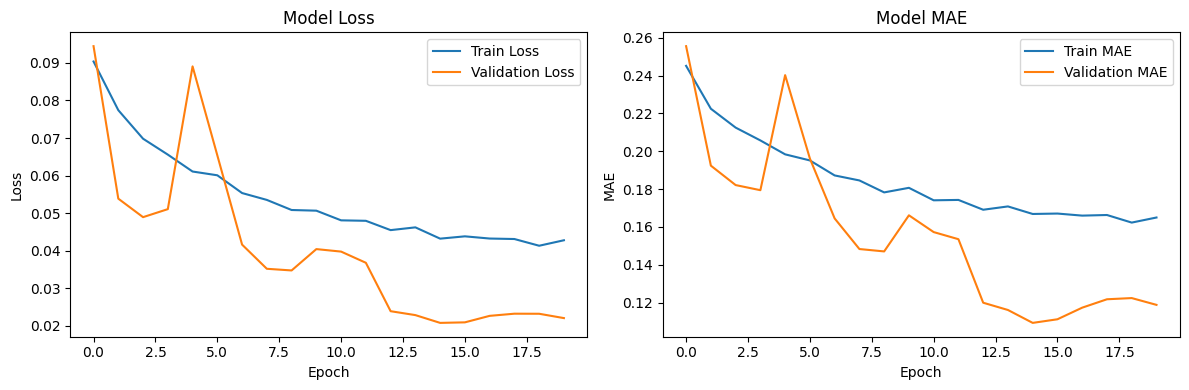


Step 6: Testing on selected videos...

Testing on smile2.avi...

Testing on chew.avi...

Test Results:

smile2.avi:
  Average FPS: 1.51
  Min FPS: 0.12
  Max FPS: 1.88

chew.avi:
  Average FPS: 1.63
  Min FPS: 1.28
  Max FPS: 1.92

Saving model...
Full model saved to: pose_detection_model_6points.keras
Model weights saved to: pose_detection_model_6points.weights.h5

Model saved successfully!


In [4]:
# Step 6: Evaluation and Visualization

def evaluate_pose_accuracy(model, test_data, threshold=0.1):
    """Evaluate model accuracy using PCK metric with improved distance calculation."""
    predictions = model.predict(test_data[0], verbose=0)
    
    # Reshape predictions and ground truth to (samples, 3, 2)
    pred_coords = predictions.reshape(-1, 3, 2)
    true_coords = test_data[1].reshape(-1, 3, 2)
    
    # Calculate normalized distances for each keypoint
    distances = np.zeros_like(pred_coords[:, :, 0])
    for i in range(pred_coords.shape[0]):
        for j in range(3):  # 3 keypoints
            # Calculate Euclidean distance in normalized coordinates
            dist = np.sqrt(
                (pred_coords[i, j, 0] - true_coords[i, j, 0])**2 +
                (pred_coords[i, j, 1] - true_coords[i, j, 1])**2
            )
            distances[i, j] = dist
    
    # Calculate PCK for each keypoint
    pck_per_keypoint = np.mean(distances < threshold, axis=0)
    overall_pck = np.mean(pck_per_keypoint)
    
    print("\nPCK results:")
    print(f"Average distance per keypoint:")
    for i, dist in enumerate(np.mean(distances, axis=0)):
        print(f"Keypoint {i+1}: {dist:.4f}")
    
    print(f"\nDetailed predictions for first sample:")
    print("Predicted keypoints:")
    print(pred_coords[0])
    print("True keypoints:")
    print(true_coords[0])
    
    print(f"\nPCK per keypoint (threshold={threshold}):")
    for i, pck in enumerate(pck_per_keypoint):
        print(f"Keypoint {i+1}: {pck:.4f}")
    print(f"Overall PCK: {overall_pck:.4f}")
    
    return overall_pck

def plot_training_history(history):
    """Plot training metrics."""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def save_model_and_weights(model, base_path):
    """Save model and weights with proper extensions."""
    try:
        # Save full model in Keras format
        keras_path = f"{base_path}.keras"
        model.save(keras_path)
        print(f"Full model saved to: {keras_path}")
        
        # Save weights with correct extension
        weights_path = f"{base_path}.weights.h5"
        model.save_weights(weights_path)
        print(f"Model weights saved to: {weights_path}")
        
        return True
    except Exception as e:
        print(f"Error saving model: {str(e)}")
        return False


def visualize_predictions(model, test_image, true_keypoints=None):
    """Visualize predicted keypoints on an image with improved visualization."""
    img = test_image.copy()
    if len(img.shape) == 3:
        img = np.expand_dims(img, axis=0)
    
    # Get predictions
    pred_keypoints = model.predict(img, verbose=0)[0]
    pred_keypoints = pred_keypoints.reshape(3, 2)
    
    # Create visualization
    viz_img = (test_image * 255).astype(np.uint8).copy()
    h, w = test_image.shape[:2]
    
    # Scale keypoints back to image coordinates
    pred_keypoints_scaled = pred_keypoints.copy()
    pred_keypoints_scaled[:, 0] *= w
    pred_keypoints_scaled[:, 1] *= h
    
    # Colors for different keypoints
    colors = [
        (0, 255, 0),  # Green for keypoint 1
        (255, 0, 0),  # Blue for keypoint 2
        (0, 0, 255)   # Red for keypoint 3
    ]
    
    # Draw predicted keypoints
    for i, (x, y) in enumerate(pred_keypoints_scaled):
        cv2.circle(viz_img, (int(x), int(y)), 4, colors[i], -1)
        cv2.putText(viz_img, f'P{i+1}', (int(x)+5, int(y)+5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[i], 1)
    
    # Draw ground truth keypoints if available
    if true_keypoints is not None:
        true_keypoints = true_keypoints.reshape(3, 2)
        true_keypoints_scaled = true_keypoints.copy()
        true_keypoints_scaled[:, 0] *= w
        true_keypoints_scaled[:, 1] *= h
        
        for i, (x, y) in enumerate(true_keypoints_scaled):
            cv2.circle(viz_img, (int(x), int(y)), 2, (255, 255, 255), -1)
            cv2.putText(viz_img, f'T{i+1}', (int(x)-20, int(y)-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return viz_img
    
class PoseTestingUtils:
    def __init__(self, model, test_data, output_dir="test_results"):
        """Initialize testing utilities."""
        self.model = model
        self.test_data = test_data
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
    
    def test_on_video(self, video_path):
        """Test model performance on a full video."""
        cap = cv2.VideoCapture(video_path)
        video_name = os.path.basename(video_path).split('.')[0]
        results = []
        fps_list = []
        
        # Create output video writer
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(
            os.path.join(self.output_dir, f"{video_name}_output.avi"),
            fourcc, 30.0, (192, 192)
        )
        
        while True:
            success, frame = cap.read()
            if not success:
                break
            
            # Process frame
            start_time = time.time()
            processed_frame = self._process_single_frame(frame)
            end_time = time.time()
            
            # Calculate FPS
            fps = 1 / (end_time - start_time)
            fps_list.append(fps)
            
            # Save processed frame
            out.write(processed_frame)
            results.append(processed_frame)
        
        cap.release()
        out.release()
        
        # Save performance metrics
        avg_fps = np.mean(fps_list)
        metrics = {
            'average_fps': avg_fps,
            'min_fps': np.min(fps_list),
            'max_fps': np.max(fps_list)
        }
        
        return metrics
    
    def _process_single_frame(self, frame):
        """Process a single frame for visualization."""
        # Resize and normalize
        frame = cv2.resize(frame, (192, 192))
        normalized_frame = frame.astype(np.float32) / 255.0
        
        # Get predictions
        predictions = self.model.predict(np.expand_dims(normalized_frame, axis=0), verbose=0)
        
        # Draw predictions
        output_frame = self._draw_predictions(frame, predictions[0])
        return output_frame
    
    def _draw_predictions(self, frame, predictions):
        """Draw keypoint predictions on frame."""
        h, w = frame.shape[:2]
        predictions = predictions.reshape(3, 2)
        
        colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]
        for i, (x, y) in enumerate(predictions):
            x_px = int(x * w)
            y_px = int(y * h)
            cv2.circle(frame, (x_px, y_px), 4, colors[i], -1)
            cv2.putText(frame, f'K{i+1}', (x_px+5, y_px+5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[i], 1)
        
        return frame
    
    def test_robustness(self):
        """Test model robustness under different conditions."""
        print("Testing model robustness...")
        
        # Test different lighting conditions
        lighting_results = self._test_lighting_variations()
        
        # Test different angles
        angle_results = self._test_angle_variations()
        
        # Test with occlusions
        occlusion_results = self._test_occlusions()
        
        return {
            'lighting': lighting_results,
            'angles': angle_results,
            'occlusions': occlusion_results
        }
    
    def _test_lighting_variations(self):
        """Test model under different lighting conditions."""
        variations = [(0.5, 'dark'), (1.0, 'normal'), (1.5, 'bright')]
        results = {}
        
        for factor, condition in variations:
            modified_data = self.test_data[0] * factor
            modified_data = np.clip(modified_data, 0, 1)
            
            predictions = self.model.predict(modified_data, verbose=0)
            pck = self._calculate_pck(predictions, self.test_data[1])
            
            results[condition] = pck
        
        return results
    
    def _test_angle_variations(self):
        """Test model with different viewing angles."""
        angles = [0, 15, 30, -15, -30]
        results = {}
        
        for angle in angles:
            rotated_data = self._rotate_images(self.test_data[0], angle)
            predictions = self.model.predict(rotated_data, verbose=0)
            pck = self._calculate_pck(predictions, self.test_data[1])
            
            results[f'angle_{angle}'] = pck
        
        return results
    
    def _test_occlusions(self):
        """Test model with partial occlusions."""
        occlusion_types = ['top', 'bottom', 'left', 'right']
        results = {}
        
        for occlusion in occlusion_types:
            occluded_data = self._add_occlusions(self.test_data[0], occlusion)
            predictions = self.model.predict(occluded_data, verbose=0)
            pck = self._calculate_pck(predictions, self.test_data[1])
            
            results[occlusion] = pck
        
        return results
    
    def _calculate_pck(self, predictions, ground_truth, threshold=0.2):
        """Calculate PCK metric."""
        pred_coords = predictions.reshape(-1, 3, 2)
        true_coords = ground_truth.reshape(-1, 3, 2)
        
        distances = np.sqrt(np.sum((pred_coords - true_coords) ** 2, axis=2))
        pck = np.mean(distances < threshold)
        
        return pck
    
    def _rotate_images(self, images, angle):
        """Rotate images by given angle."""
        rotated = []
        for img in images:
            center = (img.shape[1] // 2, img.shape[0] // 2)
            matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated_img = cv2.warpAffine(img, matrix, (img.shape[1], img.shape[0]))
            rotated.append(rotated_img)
        return np.array(rotated)
    
    def _add_occlusions(self, images, occlusion_type):
        """Add occlusions to images."""
        occluded = []
        for img in images:
            img_copy = img.copy()
            h, w = img.shape[:2]
            
            if occlusion_type == 'top':
                img_copy[:h//3, :] = 0
            elif occlusion_type == 'bottom':
                img_copy[2*h//3:, :] = 0
            elif occlusion_type == 'left':
                img_copy[:, :w//3] = 0
            elif occlusion_type == 'right':
                img_copy[:, 2*w//3:] = 0
                
            occluded.append(img_copy)
        return np.array(occluded)
    
    def generate_test_report(self):
        """Generate comprehensive test report."""
        print("Generating test report...")
        
        # Test basic accuracy
        predictions = self.model.predict(self.test_data[0], verbose=0)
        base_pck = self._calculate_pck(predictions, self.test_data[1])
        
        # Test robustness
        robustness_results = self.test_robustness()
        
        # Test on sample video
        video_metrics = self.test_on_video(os.path.join("test_videos", "test_sample.avi"))
        
        # Create report
        report = {
            'base_accuracy': {
                'pck': base_pck
            },
            'robustness_tests': robustness_results,
            'performance_metrics': video_metrics
        }
        
        # Save report
        self._save_report(report)
        
        return report
    
    def _save_report(self, report):
        """Save test report to file."""
        report_path = os.path.join(self.output_dir, "test_report.txt")
        
        with open(report_path, 'w') as f:
            f.write("Pose Detection Model Test Report\n")
            f.write("===============================\n\n")
            
            f.write("1. Base Accuracy\n")
            f.write(f"PCK Score: {report['base_accuracy']['pck']:.4f}\n\n")
            
            f.write("2. Robustness Tests\n")
            f.write("Lighting Variations:\n")
            for condition, score in report['robustness_tests']['lighting'].items():
                f.write(f"  {condition}: {score:.4f}\n")
                
            f.write("\nAngle Variations:\n")
            for angle, score in report['robustness_tests']['angles'].items():
                f.write(f"  {angle}: {score:.4f}\n")
                
            f.write("\nOcclusion Tests:\n")
            for occlusion, score in report['robustness_tests']['occlusions'].items():
                f.write(f"  {occlusion}: {score:.4f}\n")
            
            f.write("\n3. Performance Metrics\n")
            f.write(f"Average FPS: {report['performance_metrics']['average_fps']:.2f}\n")
            f.write(f"Min FPS: {report['performance_metrics']['min_fps']:.2f}\n")
            f.write(f"Max FPS: {report['performance_metrics']['max_fps']:.2f}\n")


# Main execution

if __name__ == "__main__":
    # Set random seeds
    tf.random.set_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    # Configuration
    dataset_path = r"C:\Users\uppal\Desktop\HumanPoseDetection"
    output_path = "frames"
    augmented_path = "augmented_frames"
    
    try:
        # Step 1: Process videos
        print("\nStep 1: Processing videos...")
        all_videos = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) 
                     if f.endswith(('.mp4', '.avi', '.mov'))]
        
        # Select training videos
        selected_videos = random.sample(all_videos, min(12, len(all_videos)))
        print(f"Selected videos for training: {selected_videos}")
        
        # Select exactly 2 videos for testing
        test_videos = random.sample([v for v in all_videos if v not in selected_videos], 2)
        print(f"\nSelected videos for testing: {test_videos}")
        
        # Process training videos
        for video in selected_videos:
            video_name = os.path.basename(video).split('.')[0]
            output_dir = os.path.join(output_path, video_name)
            extract_frames(video, output_dir)
        
        # Steps 2-5 (your existing training code)
        print("\nStep 2: Augmenting data...")
        process_videos(output_path, augmented_path)
        
        print("\nStep 3: Preparing dataset...")
        frames, keypoints = prepare_dataset(output_path)
        train_data, val_data, test_data = split_dataset(frames, keypoints)
        
        print("\nStep 4: Training model...")
        model, history = train_pose_model(train_data, val_data)
        
        print("\nStep 5: Basic evaluation...")
        plot_training_history(history)
        
        # Step 6: Test on the 2 selected videos
        print("\nStep 6: Testing on selected videos...")
        tester = PoseTestingUtils(model, test_data, output_dir="test_results")
        
        video_results = {}
        for test_video in test_videos:
            video_name = os.path.basename(test_video)
            print(f"\nTesting on {video_name}...")
            metrics = tester.test_on_video(test_video)
            video_results[video_name] = metrics
            
        # Print test results
        print("\nTest Results:")
        for video_name, metrics in video_results.items():
            print(f"\n{video_name}:")
            print(f"  Average FPS: {metrics['average_fps']:.2f}")
            print(f"  Min FPS: {metrics['min_fps']:.2f}")
            print(f"  Max FPS: {metrics['max_fps']:.2f}")
        
        # Save model
        print("\nSaving model...")
        save_success = save_model_and_weights(model, 'pose_detection_model_6points')
        if save_success:
            print("\nModel saved successfully!")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise